# K-Means Clustering

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score,f1_score


#Set figure size
sns.set(rc={'figure.figsize':(5,5)})

#Load data
df = pd.read_csv(os.path.join('data','data_filtered.csv'))
df2 = pd.read_csv(os.path.join('data','data_all.csv'))

#Enable CUDA
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

df

,sd,Q25,IQR,sp.ent,sfm,meanfun,mindom,dfrange,label
0,0.241585,0.455971,-0.601712,0.796058,0.925288,1.302489,-0.708404,-0.415794,1
1,-0.114476,-0.105393,0.401743,0.461699,-0.229014,-0.259737,-0.461523,0.412186,0
2,-1.284107,1.726540,-1.169425,-1.599113,-1.269425,1.315527,-0.461523,1.777355,1
3,1.089943,-0.391539,0.786946,0.578250,0.982092,-0.698228,-0.708404,-0.679948,0
4,0.231523,0.681061,-0.527833,0.508050,0.516462,1.167348,-0.708404,-1.343664,1
...,...,...,...,...,...,...,...,...,...
3163,1.087355,-0.480803,0.982768,1.385949,1.667369,-0.969765,-0.338082,-1.208257,0
3164,-1.471392,0.863030,-1.176833,-0.555301,-1.128432,0.530223,1.143207,-1.214917,1
3165,0.644400,-0.395149,0.953317,0.626947,0.305185,-0.983770,-0.708404,-0.688828,0
3166,1.557415,-0.558784,0.970942,1.076622,1.232644,-0.441604,-0.708404,-0.005133,0


In [3]:
feature_size = len(df.drop(['label'],axis=1).columns)
print(f'Number of Features: {feature_size}')

train_x, test_x, train_y, test_y = train_test_split(
    df.drop(['label'], axis=1), df['label'], test_size=0.2, random_state=42)


Number of Features: 8


In [4]:
def run(init: str = 'k-means++',  # Selection of inital clusters
        n_init: int = 10,         # Number of times the algorithm is ran with different centroid seeds                                
        tol: float = 1e-4,        # Relative tolerance with regards to Frobenius norm to declare convergence
        show: bool = True):
    kmeans = KMeans(n_clusters=2, init=init, n_init=n_init,
                    tol=tol).fit(train_x, train_y)
    
    prediction = kmeans.predict(test_x)

    accuracy = accuracy_score(prediction, test_y)
    precision = precision_score(prediction, test_y)
    recall = recall_score(prediction, test_y)
    f1 = f1_score(prediction, test_y)
    
    if not show:
        return [accuracy, precision, recall, f1]
    
    #Generate confusion matrix
    cm = confusion_matrix(test_y, prediction)
    count      = ["{0:0.0f}".format(v) for v in cm.flatten()]
    percentage = ["{0:.2%}".format(v) for v in cm.flatten()/np.sum(cm)]
    labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in
              zip(count,percentage)]).reshape(2,2)
    sns.heatmap(cm,fmt='',annot=labels)
    
    # Print to standard output
    print('Accuracy:\t%.3f' % accuracy)
    print('Precision:\t%.3f' % precision)
    print('Recall:  \t%.3f' % recall)
    print('F1 Score:\t%.3f' % f1)
    
    return [accuracy,precision,recall,f1]

# Evaluation

## Selection of Initial Clustering

The initial clusters may be selected using <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">sampling based on an empirical probability distribution of the points' contribution to the overall inertia.</a> Otherwise they may be selected randomley.

Accuracy:	0.148
Precision:	0.262
Recall:  	0.210
F1 Score:	0.233


[0.14826498422712933,
 0.26198083067092653,
 0.20971867007672634,
 0.23295454545454547]

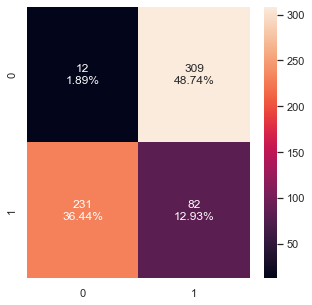

In [5]:
run(init='random')

Accuracy:	0.852
Precision:	0.738
Recall:  	0.951
F1 Score:	0.831


[0.8517350157728707,
 0.7380191693290735,
 0.9506172839506173,
 0.8309352517985611]

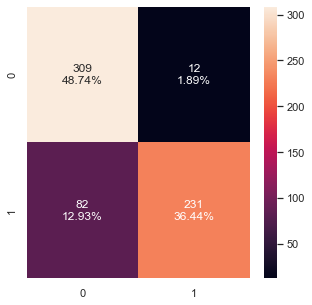

In [6]:
run(init='k-means++')

## Tendency to diverge
When the algorithm is ran with the default parameters, it sometimes performs ok, and other times it performs poorly

In [7]:
data = []
for _ in range(100):
    
    #Evaluate SVM with current C parameter
    a,p,r,f = run(show=False)
    
    #Tally metrics
    data.append([a,p,r,f])

metrics_df = pd.DataFrame(data,columns=['Accuracy','Prediction','Recall','F1 Score'])

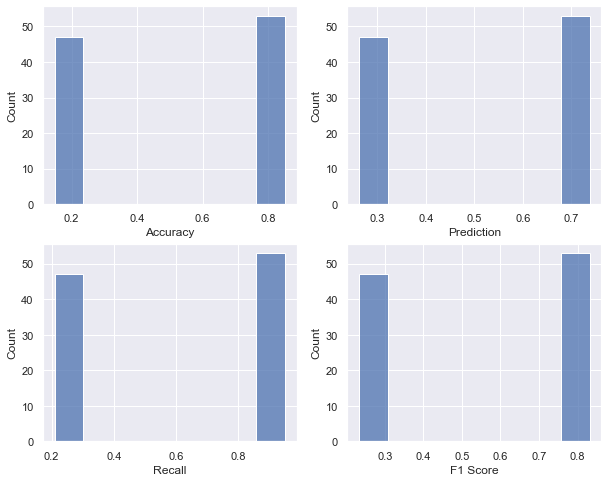

In [8]:
sns.set(rc={'figure.figsize':(10,8)})
fig,ax = plt.subplots(2,2)

sns.histplot(data=metrics_df, x='Accuracy', ax=ax[0][0])
sns.histplot(data=metrics_df, x='Prediction', ax=ax[0][1])
sns.histplot(data=metrics_df, x='Recall', ax=ax[1][0])
sns.histplot(data=metrics_df, x='F1 Score', ax=ax[1][1])

plt.show()

## Varying the tolerance to declare convergence

In [9]:
data = []
for tol in np.arange(1e-5,1e-3,1e-5):
    
    a,p,r,f = run(tol=tol, show=False)
    
    #Tally metrics
    data.append([tol,a,p,r,f])

metrics_df = pd.DataFrame(data,columns=['tol','Accuracy','Prediction','Recall','F1 Score'])

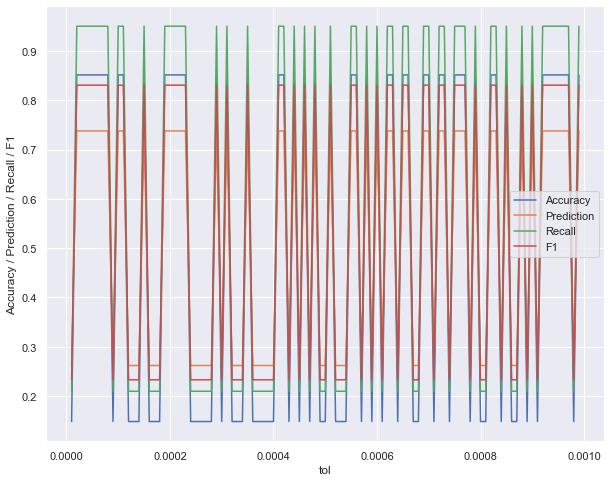

In [10]:
sns.set(rc={'figure.figsize':(10,8)})
fig,ax = plt.subplots(1,1)

sns.lineplot(data=metrics_df, x='tol',y='Accuracy', ax=ax)
sns.lineplot(data=metrics_df, x='tol',y='Prediction', ax=ax)
sns.lineplot(data=metrics_df, x='tol',y='Recall', ax=ax)
sns.lineplot(data=metrics_df, x='tol',y='F1 Score', ax=ax)

ax.set_ylabel("Accuracy / Prediction / Recall / F1")
ax.legend(["Accuracy","Prediction","Recall","F1"])

plt.show()

As we can see from the above graph, the tolerance does not affect the constant bifurcation happening in the training.

# Conclusion
The K-Means Classifier has a tendency to misplace the centroids and give poor results. The lowest accuracy was around 0.15, while the highest was 0.85. The centroids seem to converge to the same point in euclidian space each time, however when they perform poorly, it is because they are classifying the opposite of what they're supposed to classify.

In [17]:
def run_with_centroids(init: str = 'k-means++',  # Selection of inital clusters
        n_init: int = 10,         # Number of times the algorithm is ran with different centroid seeds                                
        tol: float = 1e-4,        # Relative tolerance with regards to Frobenius norm to declare convergence
        show: bool = True):
    kmeans = KMeans(n_clusters=2, init=init, n_init=n_init,
                    tol=tol).fit(train_x, train_y)
    print('Centroids:')
    print(kmeans.cluster_centers_)
    
    prediction = kmeans.predict(test_x)

    accuracy = accuracy_score(prediction, test_y)
    precision = precision_score(prediction, test_y)
    recall = recall_score(prediction, test_y)
    f1 = f1_score(prediction, test_y)
    
    if not show:
        return [accuracy, precision, recall, f1]
    
    #Generate confusion matrix
    cm = confusion_matrix(test_y, prediction)
    count      = ["{0:0.0f}".format(v) for v in cm.flatten()]
    percentage = ["{0:.2%}".format(v) for v in cm.flatten()/np.sum(cm)]
    labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in
              zip(count,percentage)]).reshape(2,2)
    sns.heatmap(cm,fmt='',annot=labels)
    
    # Print to standard output
    print('Accuracy:\t%.3f' % accuracy)
    print('Precision:\t%.3f' % precision)
    print('Recall:  \t%.3f' % recall)
    print('F1 Score:\t%.3f' % f1)
    
    return [accuracy,precision,recall,f1]

Below are the centroids when getting a good accuracy:

Centroids:
[[ 0.60994817 -0.56530154  0.61027014  0.56724951  0.53963519 -0.50214537
  -0.25107006 -0.30837759]
 [-1.03198099  0.95094484 -1.02871261 -0.94219268 -0.9053732   0.81967462
   0.43252323  0.52681622]]
Accuracy:	0.852
Precision:	0.738
Recall:  	0.951
F1 Score:	0.831


[0.8517350157728707,
 0.7380191693290735,
 0.9506172839506173,
 0.8309352517985611]

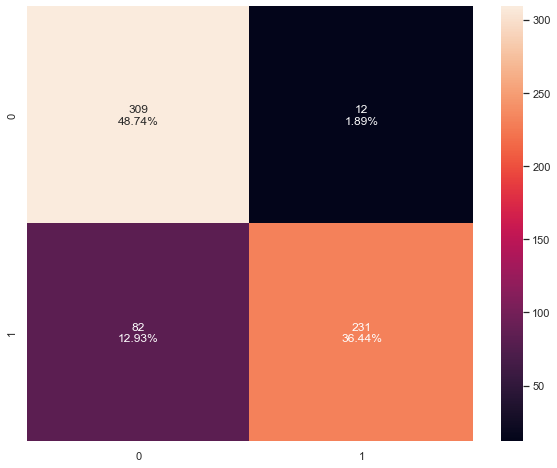

In [20]:
run_with_centroids()

Below are the centroids when getting a bad accuracy. As you can see, they are swapped:

Centroids:
[[-1.03198099  0.95094484 -1.02871261 -0.94219268 -0.9053732   0.81967462
   0.43252323  0.52681622]
 [ 0.60994817 -0.56530154  0.61027014  0.56724951  0.53963519 -0.50214537
  -0.25107006 -0.30837759]]
Accuracy:	0.148
Precision:	0.262
Recall:  	0.210
F1 Score:	0.233


[0.14826498422712933,
 0.26198083067092653,
 0.20971867007672634,
 0.23295454545454547]

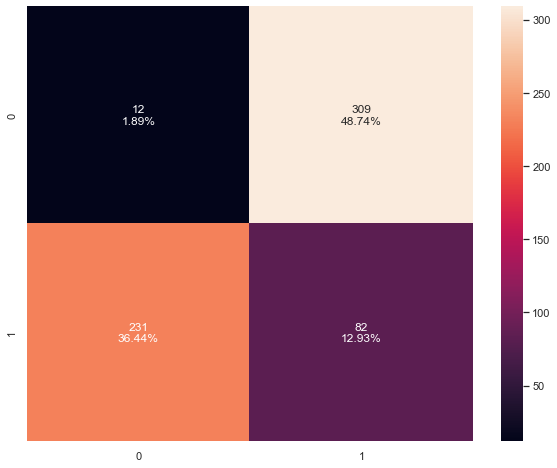

In [22]:
run_with_centroids()

The best classifier that could be trained was capped at 85% accuracy.